In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
regression_columns = ['1B', '2B', '3B', 'HR', 'HBP+BB', 'SB', 'CS']
regression_2_columns = ['SLG', 'OBP']
target = 'R'

In [3]:
def single(df):
    df['1B'] = df['H'] - (df['2B'] + df['3B'] + df['HR'])
    return df

def hbp_plus_bb(df):
    df['HBP+BB'] = df['HBP'] + df['BB']
    return df

def obp_plus_slg(df):
    df['OBP+SLG'] = df['OBP'] + df['SLG']
    return df

In [4]:
transformers = [
    single,
    hbp_plus_bb,
    obp_plus_slg,
]

df = pd.read_csv('../../data/mlb/season_stats.csv', index_col=None)

for transformer in transformers:
    df = transformer(df)

In [5]:
print(df.season.unique())

df.head()

[2021 2022]


,season,team,#Bat,BatAge,R/G,G,PA,AB,R,H,...,TB,GDP,HBP,SH,SF,IBB,LOB,1B,HBP+BB,OBP+SLG
0,2021,1,64,29.2,4.46,162,6016,5437,723,1331,...,2212,107,59,30,25,35,1029,853,523,0.717
1,2021,2,64,28.9,4.19,162,6144,5489,679,1297,...,2099,99,54,32,28,24,1152,814,591,0.691
2,2021,3,56,28.2,4.91,161,6056,5363,790,1307,...,2333,81,67,32,43,36,1072,779,616,0.754
3,2021,4,62,26.7,4.07,162,5983,5420,659,1296,...,2177,105,65,14,31,12,1046,820,516,0.706
4,2021,5,56,28.0,5.12,162,6122,5495,829,1434,...,2467,100,61,10,42,22,1093,862,573,0.777


In [6]:
corr = df[[target] + regression_columns].corr()
corr

,R,1B,2B,3B,HR,HBP+BB,SB,CS
R,1.000000,0.108313,0.545314,-0.174907,0.782613,0.605161,-0.138213,-0.248549
1B,0.108313,1.000000,0.318812,0.047699,-0.287154,-0.315436,-0.124677,-0.080625
2B,0.545314,0.318812,1.000000,-0.108932,0.121908,0.128249,-0.293802,-0.255625
3B,-0.174907,0.047699,-0.108932,1.000000,-0.357461,-0.180243,0.233613,0.218827
HR,0.782613,-0.287154,0.121908,-0.357461,1.000000,0.547064,-0.045043,-0.183756
HBP+BB,0.605161,-0.315436,0.128249,-0.180243,0.547064,1.000000,-0.203806,-0.185738
SB,-0.138213,-0.124677,-0.293802,0.233613,-0.045043,-0.203806,1.000000,0.566592
CS,-0.248549,-0.080625,-0.255625,0.218827,-0.183756,-0.185738,0.566592,1.000000


<AxesSubplot: >

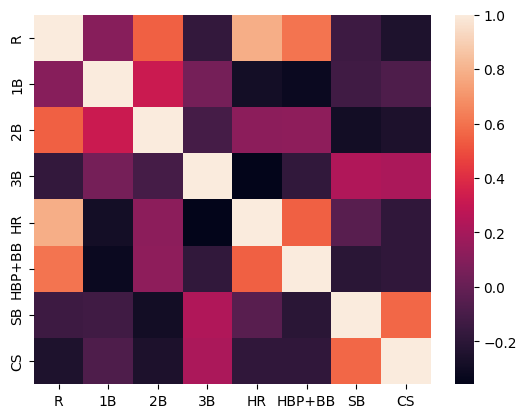

In [7]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [8]:
def setup_model(df, columns):
    y = df[target]
    X = sm.add_constant(df.loc[:, columns])

    return X, y

X, y = setup_model(df, regression_columns)

est = sm.OLS(y, X)
est = est.fit()

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     106.4
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           1.58e-28
Time:                        05:03:21   Log-Likelihood:                -260.42
No. Observations:                  60   AIC:                             536.8
Df Residuals:                      52   BIC:                             553.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -357.5865     61.240     -5.839      0.0

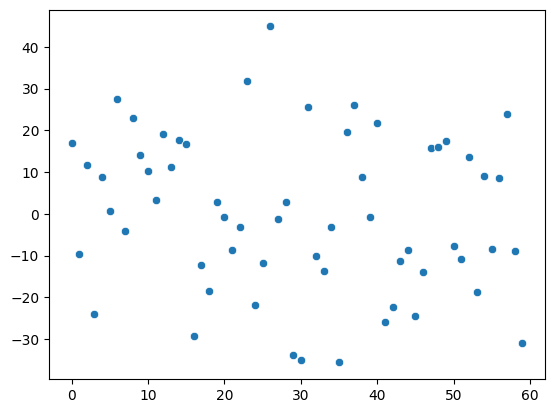

In [9]:
def print_summary(est, columns):
    print(est.summary())
    print()
    print('p-values')
    for i, column in enumerate(columns):
        print({column: (est.pvalues[i], est.pvalues[i] < .05)})

    ## pattern == hetroscedastic (no constant var), fan-out == homoscedastic (constant var)
    sns.scatterplot(data=est.resid)

print_summary(est, X.columns)

In [10]:
df_pred = df.loc[:, ['team', 'R']]

df_pred['PRED_R'] = est.predict(X)
df_pred['ABS_DIFF'] = (df_pred.R - df_pred.PRED_R).abs()

df_pred.head()

,team,R,PRED_R,ABS_DIFF
0,1,723,705.945866,17.054134
1,2,679,688.713207,9.713207
2,3,790,778.302548,11.697452
3,4,659,683.092601,24.092601
4,5,829,820.085221,8.914779


In [11]:
print('off by an average of:', df_pred.ABS_DIFF.mean(), 'runs')

off by an average of: 15.648752733079606 runs


### SLG / OBP contributions vs runs

<AxesSubplot: title={'center': 'OBP'}, xlabel='OBP', ylabel='Count'>

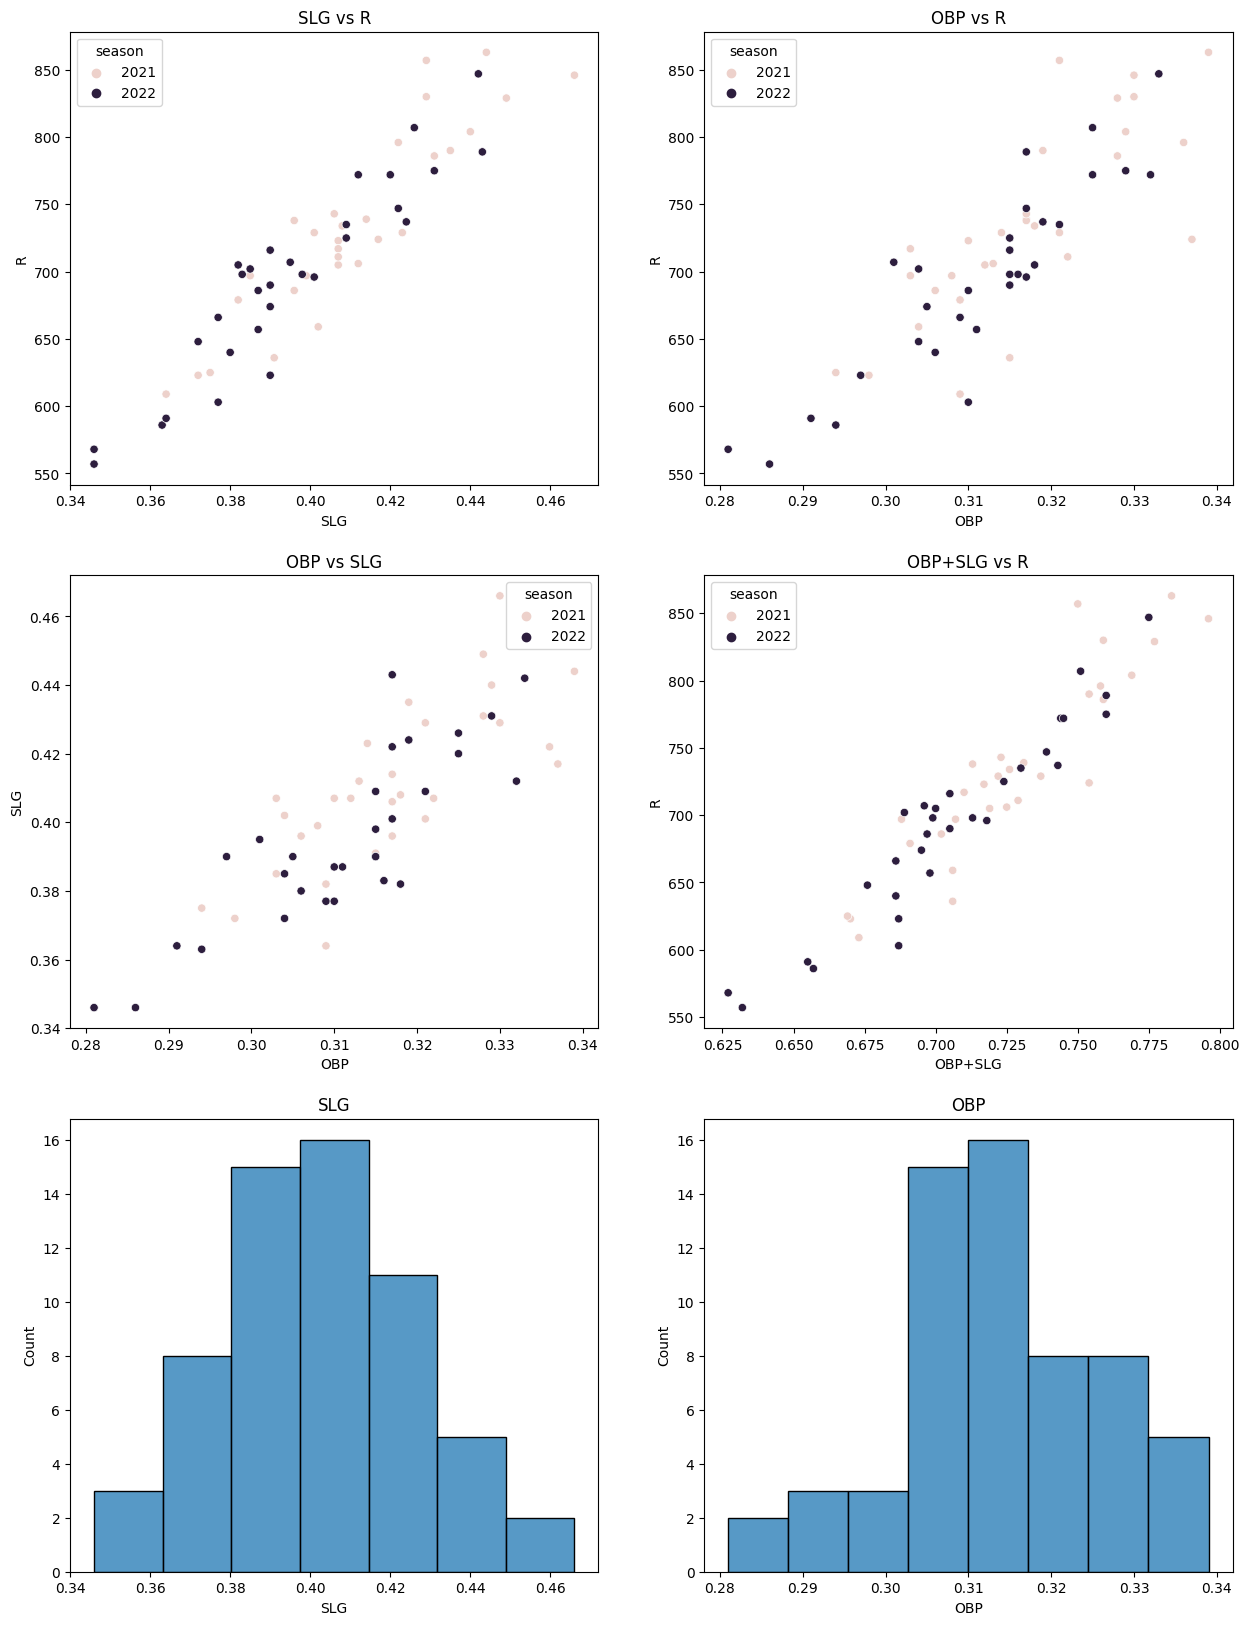

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

axes[0, 0].set_title('SLG vs R')
sns.scatterplot(ax=axes[0, 0], data=df, x='SLG', y='R', hue='season')

axes[0, 1].set_title('OBP vs R')
sns.scatterplot(ax=axes[0, 1], data=df, x='OBP', y='R', hue='season')

axes[1, 0].set_title('OBP vs SLG')
sns.scatterplot(ax=axes[1, 0], data=df, x='OBP', y='SLG', hue='season')

axes[1, 1].set_title('OBP+SLG vs R')
sns.scatterplot(ax=axes[1, 1], data=df, x='OBP+SLG', y='R', hue='season')

axes[2, 0].set_title('SLG')
sns.histplot(ax=axes[2, 0], data=df.SLG)

axes[2, 1].set_title('OBP')
sns.histplot(ax=axes[2, 1], data=df.OBP)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     223.4
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           1.07e-27
Time:                        05:03:23   Log-Likelihood:                -276.92
No. Observations:                  60   AIC:                             559.8
Df Residuals:                      57   BIC:                             566.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -619.3205     87.111     -7.110      0.0

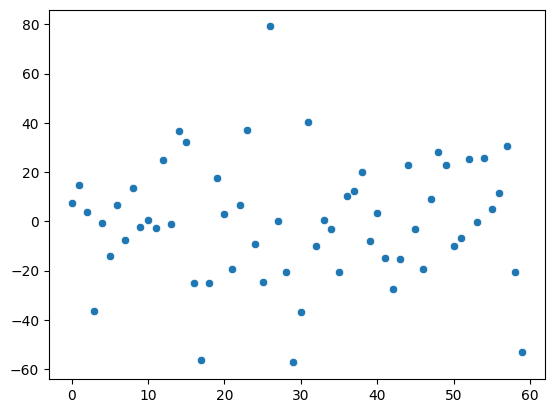

In [13]:
def setup_model(df, columns):
    y = df[target]
    X = sm.add_constant(df.loc[:, columns])

    return X, y

X, y = setup_model(df, regression_2_columns)

est = sm.OLS(y, X)
est = est.fit()

print_summary(est, X.columns)

#### Contributions for OBP+SLG

In [14]:
slg_param = est.params['SLG']
obp_param = est.params['OBP']

print(obp_param / slg_param)
print(slg_param / obp_param)

0.8569748764165469
1.166895351916867
